In [2]:
#import uproot4 as uproot
import uproot 
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward as ak
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

In [4]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [5]:
import sys,os
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")

In [6]:
from utils import *

In [7]:
#var to read
var_read_lists = ['pt2l','mass2l','EventWeight','foundZ1LCandidate','foundTTCRCandidate','foundZ2JCandidate','foundZ2MergedCandidata','foundTTCRCandidate','passedfullmerged','passedfullresolved','particleNetZvsQCD','passedNassociated','isEE','isMuMu',
                        'massmerged','ptmerged',
                        'pt2jet','mass2jet',
                        'mass2l2jet', 'mass2lj',
                        'KD_jjVBF',
                         'isbjet','iscjet','islightjet']

In [8]:
ori_dir = '/cms/user/guojl/Sample/2L2Q/UL_Legacy/2016/'
samples_inf = {#name path cross Section
                    #'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 363.8142],
                    'DY_pt50To100':['MC/DYJetsToLL_Pt-50To100_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8', 398.8],
                    #'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',84.014804],
                    'DY_pt100To250':['MC/DYJetsToLL_Pt-100To250_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',93.61],
                    'DY_pt250To400':['MC/DYJetsToLL_Pt-250To400_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.67],#3.047],
                    'DY_pt400To650':['MC/DYJetsToLL_Pt-400To650_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.5],#0.392],
                    'DY_pt650ToInf':['MC/DYJetsToLL_Pt-650ToInf_MatchEWPDG20_TuneCP5_13TeV-amcatnloFXFX-pythia8',0.04704],#0.03636],
                    'TTJets':['MC/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8',831.76],
                    'TTTo2L2Nu':['MC/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',1],
                    'WW_TuneCP5':['MC/WW_TuneCP5_13TeV-pythia8',1],
                    'WWTo2L2Nu':['MC/WWTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',11.09],
                    'WZTo2Q2L':['MC/WZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',6.419],
                    'ZZTo2Q2L':['MC/ZZTo2Q2L_mllmin4p0_TuneCP5_13TeV-amcatnloFXFX-pythia8',3.696],
                    'ggH1000':['MC/Signal/skimed/GluGluHToZZTo2L2Q_M1000_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v17-v2_0.root',5.07],
                    'VBF1500':['MC/Signal/skimed/VBF_HToZZTo2L2Q_M1500_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8__asymptotic_v13-v1_0.root',0.77],
                    'test':'MC/test',
                    'Data':['Data/skimed/Data2016UL_noDuplicates.root',1],
                    }

Samples_lists = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf',
              'TTJets',
              'WZTo2Q2L',
              'ZZTo2Q2L',
              'WWTo2L2Nu',
              'Data']

#signal_lists = [ 'ggH1000','VBF1500']
signal_lists = [ 'ggH1000']

lumi = {2016: 16.81, 2017: 41.53, 2018: 59.74}
year=2016

bininfo = {'mass2l':[24,60,120,"M(ll)"],
              'pt2l':[70,100,800,"Pt(ll)"],
              #'massmerged':[28,40,180,"M(J)"],
              'massmerged':[40,0,200,"M(J)"],
              'ptmerged':[60,200,800,"Pt(J)"],
              'mass2l2jet':[28,40,180,"M(2l2q)"], 
              'mass2lj':[60,500,3500,"M(2l2q)"],
              'pt2jet':[70,100,800,"Pt(jj)"],
              'mass2jet':[28,40,180,"M(jj)"],
              'particleNetZvsQCD':[20,0,1,"particleNetZvsQCD"],
              'KD_jjVBF':[20,0,1,"VBF(score)"]}

cats = ['isEE','isMuMu']

In [9]:
#extract branch for each sample
bkg_array = {}
data_array = None
signal_array = {}
sumWeight = {}

for sample in Samples_lists:
    print(f"This is {sample}")
    if sample!='Data':
        indir = ori_dir+samples_inf[sample][0]+'/skimed'
        files = find_this_rootfiles(indir)
        sumWeight[sample] = 0
            
        for file in files:
            with uproot.open(f'{indir}/{file}') as f:
                this_sumWeight_h = f['sumWeights'].to_boost()
                this_sumWeight = this_sumWeight_h.sum()
                #print(f'this sum weight = {this_sumWeight}')
                sumWeight[sample] += this_sumWeight
                    
        bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=var_read_lists)
        
    else:
        data_path = ori_dir+samples_inf['Data'][0]
        data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=var_read_lists)

for sample in signal_lists:
    print(f"This is {sample}")
    signal_path = ori_dir+samples_inf[sample][0]
    
    sumWeight[sample] = 0
    with uproot.open(signal_path) as f:
        this_sumWeight_h = f['sumWeights'].to_boost()
        this_sumWeight = this_sumWeight_h.sum()
        sumWeight[sample] += this_sumWeight
        
        signal_array[sample] = f['passedEvents'].arrays(filter_name=var_read_lists,library="ak")

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is ggH1000


In [10]:
def make_cut(array,region,cat): 
    if region=='CR':
        selection = f'((massmerged<70) | (massmerged>105)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & ({cat}==True)'
        #cut_array = array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    elif region=='SR':
        selection = f'(massmerged>70) & (massmerged<105) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & ({cat}==True)'
        #cut_array = array['foundTTCRCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    else:
        print("[ERROR] only CR and SR are available")
        sys.exit()
    
    cut_array = ak.numexpr.evaluate(selection,array)
        
    #cut_array = array[cat] & array['foundZ2JCandidate'] & ((array['mass2jet']<70) | (array['mass2jet']>105)) &array['passedNassociated']#resovled
    #cut_array = array[cat] #leptonic Z
    return cut_array

In [11]:
import yaml

In [12]:
sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

In [13]:
#apply cut and for each sample
regions = ['CR','SR']
bkg_array_cut = {}; data_array_cut = {}; signal_array_cut = {}
for reg in regions:
    bkg_array_cut[reg] = {}; data_array_cut[reg] = {}; signal_array_cut[reg] = {}
    for cat in cats:
        bkg_array_cut[reg][cat] = {}; data_array_cut[reg][cat] = None; signal_array_cut[reg][cat] = {}
        for sample in Samples_lists:
            print(f"This is {sample} in {reg} in {cat}")
            if sample!='Data':
                temp_array = bkg_array[sample]
                cut_array = make_cut(temp_array,region = reg, cat = cat)
                bkg_array_cut[reg][cat][sample] = temp_array[cut_array]
            else:
                temp_array = data_array
            
                cut_array = make_cut(temp_array,region = reg, cat = cat)
                data_array_cut[reg][cat] = temp_array[cut_array]
        #for sample in signal_lists:
        #    temp_array = signal_array[sample]
        #    cut_array = make_cut(temp_array,region = reg, cat = cat)
        #    signal_array_cut[reg][cat][sample] = temp_array[cut_array]

This is DY_pt50To100 in CR in isEE
This is DY_pt100To250 in CR in isEE
This is DY_pt250To400 in CR in isEE
This is DY_pt400To650 in CR in isEE
This is DY_pt650ToInf in CR in isEE
This is TTJets in CR in isEE
This is WZTo2Q2L in CR in isEE
This is ZZTo2Q2L in CR in isEE
This is WWTo2L2Nu in CR in isEE
This is Data in CR in isEE
This is DY_pt50To100 in CR in isMuMu
This is DY_pt100To250 in CR in isMuMu
This is DY_pt250To400 in CR in isMuMu
This is DY_pt400To650 in CR in isMuMu
This is DY_pt650ToInf in CR in isMuMu
This is TTJets in CR in isMuMu
This is WZTo2Q2L in CR in isMuMu
This is ZZTo2Q2L in CR in isMuMu
This is WWTo2L2Nu in CR in isMuMu
This is Data in CR in isMuMu
This is DY_pt50To100 in SR in isEE
This is DY_pt100To250 in SR in isEE
This is DY_pt250To400 in SR in isEE
This is DY_pt400To650 in SR in isEE
This is DY_pt650ToInf in SR in isEE
This is TTJets in SR in isEE
This is WZTo2Q2L in SR in isEE
This is ZZTo2Q2L in SR in isEE
This is WWTo2L2Nu in SR in isEE
This is Data in SR i

In [19]:
massZZ_low_bins = np.linspace(500,1700,25)
massZZ_high_bins = np.array([2000,3500])
massZZ_bins = bh.axis.Variable(ak.from_numpy(np.append(massZZ_low_bins,massZZ_high_bins)).to_list())
print(f'massZZ bins = {massZZ_bins}')
#set var draw 
varbs = ['mass2lj']
for var in varbs:
    print(f"[INFO] it is {var} plot")
    nbins, xmin, xmax = bininfo[var][0], bininfo[var][1], bininfo[var][2]
    edge = np.linspace(xmin, xmax, nbins+1)
    if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
        islogY = True
    else:
        islogY = True

    #fill histo 
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for reg in regions:
        bkg_hists[reg] = {}; Data_hist[reg] = {}; signal_hists[reg] = {}
        for cat in cats:
            bkg_hists[reg][cat] = [None,None,None]; Data_hist[reg][cat] = None; signal_hists[reg][cat] = []
            for sample in Samples_lists:
                print(f"This is {sample} in {cat}")
                if sample!='Data':
                    temp_array = bkg_array_cut[reg][cat][sample]
                    #retray weight and apply paritcleNet weight
                    weights = (temp_array['EventWeight']*lumi[2016]*1000*samples_inf[sample][1])/sumWeight[sample]
                    if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                        sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                    elif sample.find('DY')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
                    elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
                    else:
                        sf_Net = ak.ones_like(temp_array['EventWeight'])
                    weights = weights*sf_Net

                    #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    temp_hist = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                    temp_hist.fill(temp_array[var],weight = weights)


                    if sample.find('DY')!=-1:
                        if (bkg_hists[reg][cat])[2]==None:
                            (bkg_hists[reg][cat])[2] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[2]+=temp_hist
                    if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        if (bkg_hists[reg][cat])[1]==None:
                            (bkg_hists[reg][cat])[1] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[1]+=temp_hist
                    if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                        if (bkg_hists[reg][cat])[0]==None:
                            (bkg_hists[reg][cat])[0] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[0]+=temp_hist
                else:
                    temp_array = data_array_cut[reg][cat]
                    weights = np.ones_like(temp_array['EventWeight'])
                    print(f'data weight  = {weights}')
                    #Data_hist[reg][cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    temp_hist = bh.Histogram(massZZ_bins)
                    temp_hist.fill(temp_array[var],weight=weights)

            #for sample in signal_lists:
            #    temp_array = signal_array_cut[cat][sample]
            #    weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
            #    sf_Net = GetParticleNetSignalSF(temp_array,tagger='ZvsQCD')
            #    weights = weights*sf_Net
            #    temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            #    signal_hists[cat].append(temp_hist)

print("Fill done")

massZZ bins = Variable(array([ 500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350.,
       1400., 1450., 1500., 1550., 1600., 1650., 1700., 2000., 3500.]))
[INFO] it is mass2lj plot
This is DY_pt50To100 in isEE
This is DY_pt100To250 in isEE
This is DY_pt250To400 in isEE
This is DY_pt400To650 in isEE
This is DY_pt650ToInf in isEE
This is TTJets in isEE
This is WZTo2Q2L in isEE
This sf_array =  [0.881, 0.975, 1.04, 0.842, 0.975, 0.842, ... 0.881, 1.11, 0.887, 0.975, 0.881]
This is ZZTo2Q2L in isEE
This sf_array =  [0.89, 1.04, 0.975, 0.842, 1.21, 1.04, ... 0.985, 0.738, 0.756, 0.918, 0.918, 0.89]
This is WWTo2L2Nu in isEE
This is Data in isEE
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is DY_pt50To100 in isMuMu
This is DY_pt100To250 in isMuMu
This is DY_pt250To400 in isMuMu
This is DY_pt400To650 in isMuMu
This is DY_pt650ToInf in isMuMu
This is TTJe

Alpha function in isEE in Merged case = [0.54393907 0.64415385 0.64941657 0.62698759 0.64053126 0.5284982
 0.50778045 0.52146726 0.35565054 0.6054763  0.41572813 0.54637125
 0.36227746 0.43948191 0.67818004 0.42577375 0.46879897 0.3384137
 0.29261901 0.46884304 0.4925096  0.33756682 0.45088185 0.28111908
 0.39307552 0.35068152]
Alpha function in isMuMu in Merged case = [0.65827027 0.68679976 0.63789044 0.68708216 0.61135725 0.52616501
 0.60928042 0.49805999 0.52212032 0.40880801 0.47925887 0.42801165
 0.46462601 0.45346613 0.43984599 0.30628388 0.51355993 0.61098701
 0.3512479  0.37516872 0.57243232 0.34844273 0.56705264 0.50065779
 0.28214322 0.53396252]


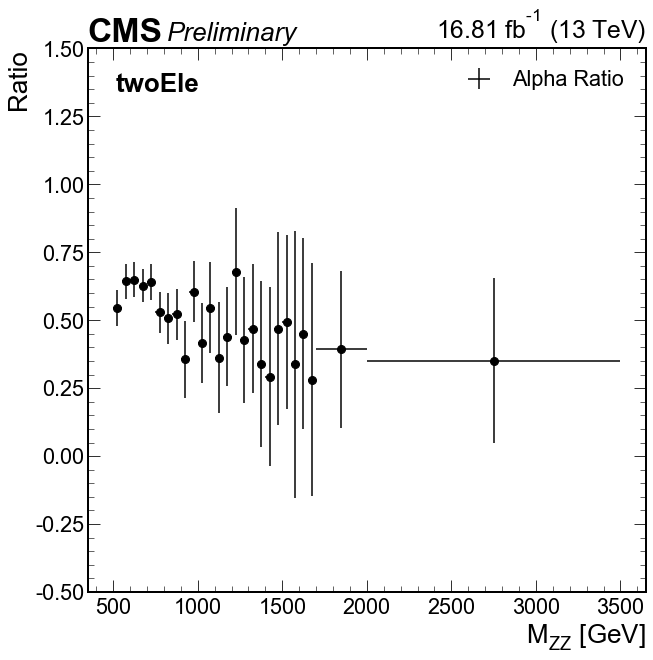

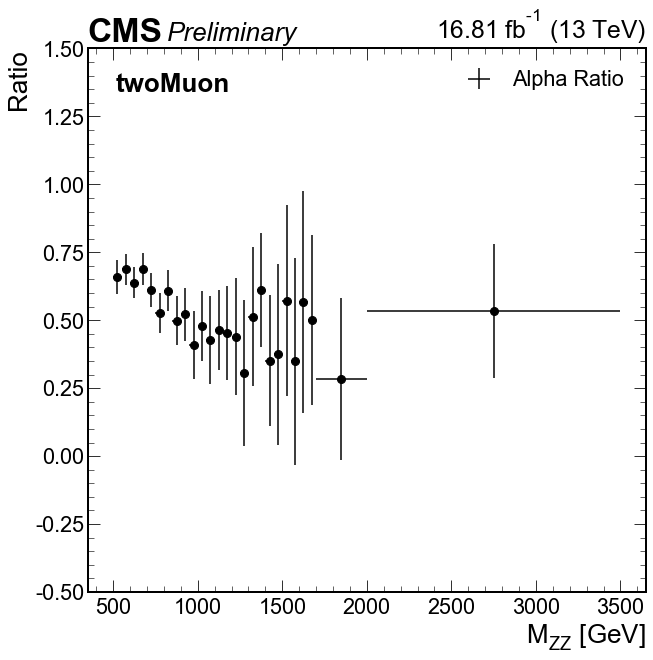

In [25]:
#produce Alpha function and store in file 
###store histo to a root file 
AlphaBranch = {}
outAlphafilepath = '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile'
#outfile = uproot.recreate(f"{outAlphafilepath}/AlphaRaio_noNETsf.root")
outfile = uproot.recreate(f"{outAlphafilepath}/AlphaRaio.root")
for cat in cats:
    if cat =='isEE':
        text = 'twoEle'
    elif cat =='isMuMu':
        text = 'twoMuon'
        
    sig_content = (bkg_hists['SR'][cat])[2].view(flow=False).value
    bkg_content = (bkg_hists['CR'][cat])[2].view(flow=False).value
    sig_content_err = get_err((bkg_hists['SR'][cat])[2])
    bkg_content_err = get_err((bkg_hists['CR'][cat])[2])
    alpha = sig_content/bkg_content
    alpha_err = np.sqrt(((sig_content_err/sig_content)*(sig_content_err/sig_content))+((bkg_content_err/bkg_content)*(bkg_content_err/bkg_content)))
    
    print(f'Alpha function in {cat} in Merged case = {alpha}')
    
    AlphaBranch[f'merged_{cat}'] = alpha
    AlphaBranch[f'merged_{cat}_err'] = alpha_err
    
    x_axis = np.append(massZZ_low_bins,massZZ_high_bins)
    
    #width = 0.15  # the width of the bars
    x_pos = []
    y_val = []
    x_err = []
    y_err = []
    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=lumi[year], ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)' %lumi[year], fontname='sans-serif')
    for i in range(0,len(x_axis)-1):
        x = (x_axis[i]+x_axis[i+1])/2
        x_pos.append(x)
        y = alpha[i]
        y_val.append(y)
        xerr = (x_axis[i+1]-x_axis[i])/2
        x_err.append(xerr)
        yerr = alpha_err[i]
        y_err.append(yerr)
        ax.plot(x,y,'o', markersize=8 ,color='black')
    ax.errorbar(x_pos,y_val,xerr=x_err,yerr=y_err,elinewidth = 1.5,linestyle='none',color='black',label = 'Alpha Ratio')

    ax.set_xlabel(r'$M_{ZZ}$ [GeV]', ha='right', x=1.0); ax.set_ylabel('Ratio', ha='right', y=1.0)
    ax.set_ylim(-0.5, 1.5)
    ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold') 
    ax.legend(loc='upper right')
outfile['alphatree'] = AlphaBranch
    

In [16]:
#draw alaph
massZZ_low_bins

array([ 500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350.,
       1400., 1450., 1500., 1550., 1600., 1650., 1700.])

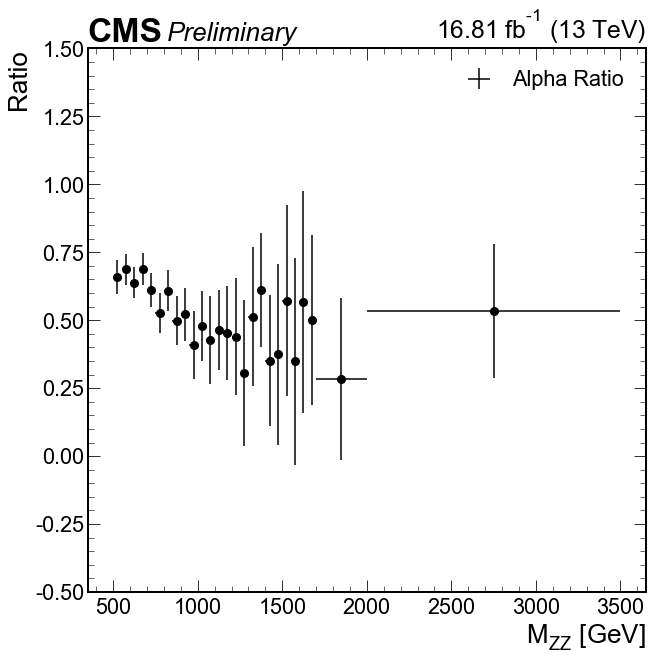

In [22]:
x_axis = np.append(massZZ_low_bins,massZZ_high_bins)
#width = 0.15  # the width of the bars
x_pos = []
y_val = []
x_err = []
y_err = []
f, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(data=True, llabel='Preliminary', year=lumi[year], ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)' %lumi[year], fontname='sans-serif')
for i in range(0,len(x_axis)-1):
    x = (x_axis[i]+x_axis[i+1])/2
    x_pos.append(x)
    y = alpha[i]
    y_val.append(y)
    xerr = (x_axis[i+1]-x_axis[i])/2
    x_err.append(xerr)
    yerr = alpha_err[i]
    y_err.append(yerr)
    ax.plot(x,y,'o', markersize=8 ,color='black')
ax.errorbar(x_pos,y_val,xerr=x_err,yerr=y_err,elinewidth = 1.5,linestyle='none',color='black',label = 'Alpha Ratio')

ax.set_xlabel(r'$M_{ZZ}$ [GeV]', ha='right', x=1.0); ax.set_ylabel('Ratio', ha='right', y=1.0)
ax.set_ylim(-0.5, 1.5)
ax.text(0.05, 0.92, 'plot_text', transform=ax.transAxes, fontweight='bold') 
ax.legend(loc='upper right')


In [23]:
alpha_err

array([0.06258739, 0.05627616, 0.05725593, 0.0585297 , 0.06319916,
       0.07289954, 0.07711125, 0.08990762, 0.09763588, 0.12517727,
       0.12890122, 0.16273965, 0.1467228 , 0.17430855, 0.21480183,
       0.26771892, 0.25601554, 0.21066689, 0.24079624, 0.33269861,
       0.35031106, 0.37939772, 0.40681528, 0.31160144, 0.29793096,
       0.24606608])

In [24]:
y_err

[0.0625873852969305,
 0.056276158682176454,
 0.05725593293325868,
 0.05852969733504751,
 0.06319916281412287,
 0.07289953757701804,
 0.07711125070107216,
 0.08990761706512432,
 0.09763587612398984,
 0.12517727110662302,
 0.12890122207837262,
 0.16273964851727568,
 0.14672279555525095,
 0.17430854607338583,
 0.2148018292290701,
 0.2677189227885445,
 0.2560155390918857,
 0.21066689431432917,
 0.24079624303832575,
 0.33269860690267566,
 0.3503110597949186,
 0.37939771870709654,
 0.40681527845526616,
 0.31160143738659796,
 0.29793096141512804,
 0.24606607853295936]